In [1]:
import glob, pdfkit, imgkit, pandas as pd, numpy as np, os
from Bio import SwissProt, SeqIO, ExPASy
import seaborn as sns, matplotlib.pyplot as plt, matplotlib.colors as mp
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import kendalltau, pearsonr
import matplotlib as mpl
os.getcwd()
seed = 46 ###seed for random sampling

# Define Functions

In [57]:
class MidpointNormalize(mpl.colors.Normalize):
    ## class from the mpl docs:
    # https://matplotlib.org/users/colormapnorms.html

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))    
    
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def mycolors(x):
    color = 'white'
    if x.name == 34 or x.name == 48:
        color = 'lightgreen'
    elif x.name == 1 or x.name == 8:
        color = 'lightblue'
    return ['background-color: '+color for v in x]

def style_table(df,column_ranking,organism):
    '''return styled table svg with ranking of a given column'''
    
    tab=df.loc[:,['Entry','Gene names', 'EC number',column_ranking, 'Num in LC']]
    tab['Num in LC']=tab['Num in LC'].astype(int)
    styles = [
                dict(props=[('font-size','20pt'),
                            ('font-family','Arial'),
                            ('text-align','center'),
                            ('width', '1500px'),
                            ('height','100px'),
                            ('display.precision', 2),
            ]),
                dict(selector='tr:nth-child(even)',props=[('background-color','whitesmoke')])]
    styled_table = (tab.style
                    .apply(lambda x: ['background: lightgreen' 
                                      if (x.name in df[df['Entry'].isin(enzyme.get(df['Ligand'][1]))].index.to_list())
                                      else '' for i in x], axis=1)
                    .set_table_styles(styles)
                    .set_precision(2)
                    .bar(vmin=0,vmax=100,subset=['Num in LC'],color='khaki'))
    return(styled_table)
    html = styled_table.render()
    imgkit.from_string(html, f"{df['Ligand'][1]}_{column_ranking.replace(' ', '_').strip(' (kcal/mol)')}{organism}.svg")
    
def correlation(tab, cmap, out):
    styles = [
        dict(props=[('font-size','50pt'),
                    ('font-family','Arial'),
                    ('text-align','center'),
                    ('width', '5000px'),
                    ('height','1000px')
    ])]
    styled_table = tab.style.set_table_styles(styles).background_gradient(vmin=tab.min().min(),
                                                                          cmap = cmap,
                                                                          vmax=tab.max().max())
    # styled_table = total_corr.style.background_gradient(vmin=0,vmax=1)
    return (styled_table)
    html = styled_table.render()
    imgkit.from_string(html, out)

# dictionary for substrate-enzyme matching ##

In [18]:
enzyme =   {'GLU':['P48320','P48318','P05202', 'P05201', 'P17174', 'P00505', 'Q99259', 'Q05329'],
            'TYR':['Q8QZR1','O88533', 'P17735', 'P20711'],
            'HIS':['P23738', 'P19113'],
            'HTL':[],#'Q6XPS7', 'P34896', 'P34897','P50431'],
            'KYN':['Q8BTY1', 'Q71RI9', 'Q9CXF0', 'Q16773', 'Q8N5Z0', 'Q6YP21', 'Q16719', 'Q9WVM8'],
            'CYT':['Q8VCN5', 'P32929'],
            'ORN':['P29758', 'P04181'],
            'THR':['P20132', 'Q8VBT2', 'Q96GA7', 'Q8R238'],
            'PLP':[]}

In [58]:
column='LCaaM (kcal/mol)'
organism='Human'
df = pd.read_csv('result/final_result/HTML_PLP_Human_1.tsv', sep = '\t')
df['Entry'] = df[df.columns[0]].str[0:6]
# mouse_proteome = pd.read_csv('https://www.uniprot.org/uniprot/?query=organism:10090&columns=id,entry%20name,reviewed,protein%20names,genes,organism,length,ec&format=tab', sep = '\t')
# human_proteome = pd.read_csv('https://www.uniprot.org/uniprot/?query=organism:9606&columns=id,entry%20name,reviewed,protein%20names,genes,organism,length,ec&format=tab', sep = '\t')
human_proteome = pd.read_csv('result/human_uniprot.tsv', sep='\t')
dlg = pd.merge(human_proteome[['Entry','Gene names','Protein names','EC number']],df, on='Entry', how='right')#.drop(['Name'], axis=1)
tabella=dlg.sort_values(by=[column]).drop_duplicates(['Entry']).reset_index(drop=True)
tabella.index+=1

#render table
style_table(tabella,'LCaaM (kcal/mol)','Homo')

,Entry,Gene names,EC number,LCaaM (kcal/mol),Num in LC
1,Q9Y617,PSAT1 PSA,2.6.1.52,-7.52,8
2,P06737,PYGL,2.4.1.1,-6.82,27
3,Q6YP21,KYAT3 CCBL2 KAT3,2.6.1.7; 4.4.1.13; 2.6.1.63,-6.80,70
4,Q16773,KYAT1 CCBL1,2.6.1.7; 4.4.1.13; 2.6.1.64,-6.32,65
5,Q96QU6,ACCS PHACS,nan,-6.28,9
6,P34897,SHMT2,2.1.2.1,-6.03,34
7,Q9HD40,SEPSECS TRNP48,2.9.1.2,-5.92,43
8,P34896,SHMT1,2.1.2.1,-5.87,19
9,P20711,DDC AADC,4.1.1.28,-5.86,12
10,O15382,BCAT2 BCATM BCT2 ECA40,2.6.1.42,-5.82,71


In [ ]:
tab=tabella.loc[:,['Entry','Gene names', 'Protein names', 'EC number','LCaaM (kcal/mol)', 'Num in LC']]
tab['Num in LC']=tab['Num in LC'].astype(int)
tab.drop('Protein names',axis=1,inplace=True)
styles = [dict(props=[('font-size','20pt'),
                      ('font-family','Arial'),
                      ('text-align','center'),
                      ('width', '1500px'),
                      ('height','300px'),
                      ('display.precision', 2),
                     ]),
          dict(selector='tr:nth-child(even)',props=[('background-color','whitesmoke')])]

styled_table = tab.round(2).style.apply(lambda x: ['background: lightgreen' 
                              if (x.name in tab[tab['Entry'].isin(enzyme.get(tabella['Ligand'][0]))].index.to_list())
                              else '' for i in x], axis=1).set_table_styles(styles).set_precision(2).bar(vmin=0,vmax=100,subset=['Num in LC'],color='khaki')
styled_table
html = styled_table.render()
# imgkit.from_string(html, df['Ligand'][0]+'_'+column.replace(" ", "_").strip(' (kcal/mol)')+'Human.jpg')

# Regression scatter plot

In [47]:
all=[]
for column in pd.read_csv('result/final_result/HTML_PLP_Human_1.tsv', sep = '\t'):
    if 'kcal' in column:
        bo = []
        for tab in glob.glob('result/final_result/*.tsv'):
            df = pd.read_csv(tab, sep = '\t')
            df['Entry'] = df[df.columns[0]].str[0:6]
            mouse_proteome = pd.read_csv('result/mouse_uniprot.tsv', sep = '\t')
            human_proteome = pd.read_csv('result/human_uniprot.tsv', sep = '\t')
            ligand = df['Ligand'][0]
            if 'Human' in tab:
                dlg = pd.merge(human_proteome[['Entry','Gene names','Protein names','Organism']],df, on='Entry', how='right')#.drop(['Name'], axis=1)
                organism = 'Human'
            else:
                dlg = pd.merge(mouse_proteome[['Entry','Gene names','Protein names','Organism']],df, on='Entry', how='right')#.drop(['Name'], axis=1)
                organism = 'Mouse'
            df1=dlg.sort_values(by=column).drop_duplicates(['Entry']).reset_index(drop=True)
            df1.index+=1
            df1[ligand]=df1.index
            df1['Gene names']=df1['Gene names'].str.split(" ", expand=True)[0]
            bo.append(df1.loc[:,['Gene names',ligand]])
        f=pd.concat(bo).groupby('Gene names').first().add_suffix(' '+column)
#         f['random']=f.iloc[:,0].sample(frac=1, n=100, random_state=seed).reset_index().drop('Gene names', axis=1).set_index(f.index)
        all.append(f)

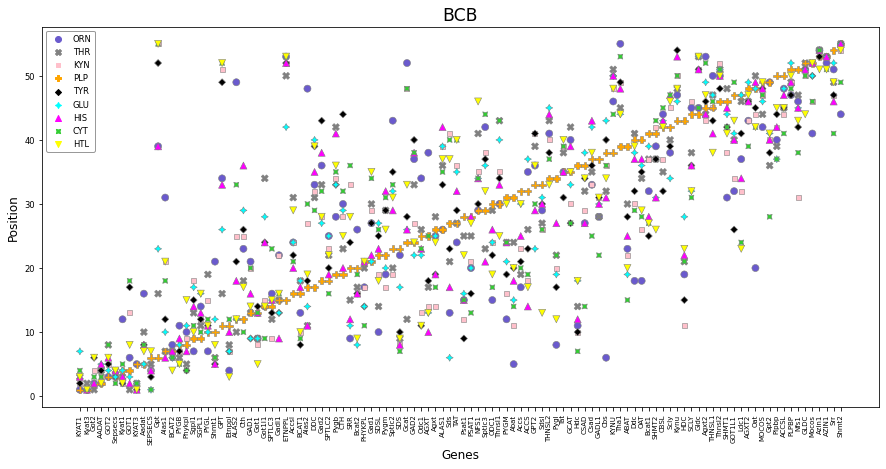

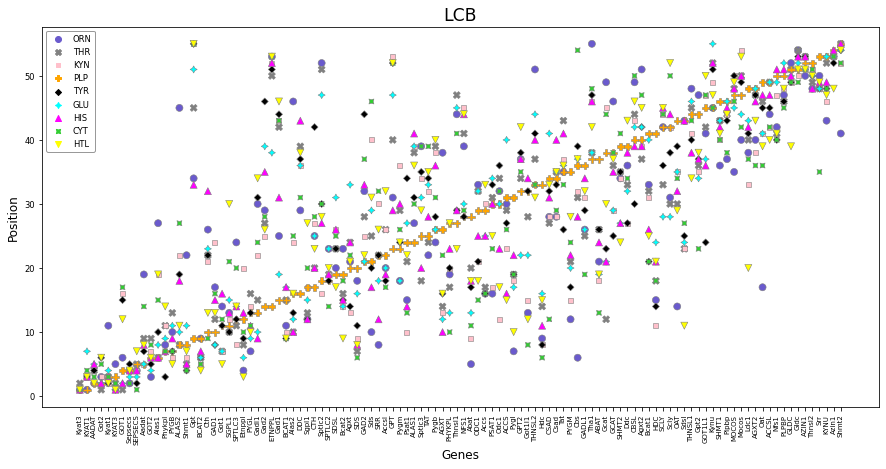

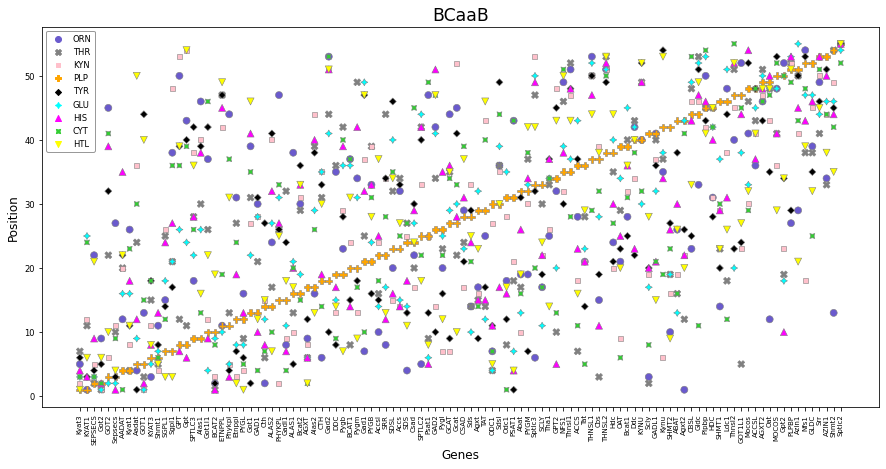

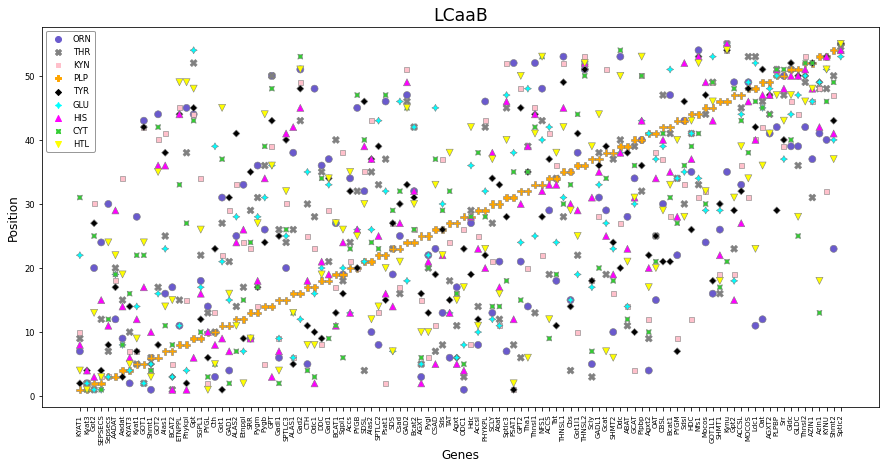

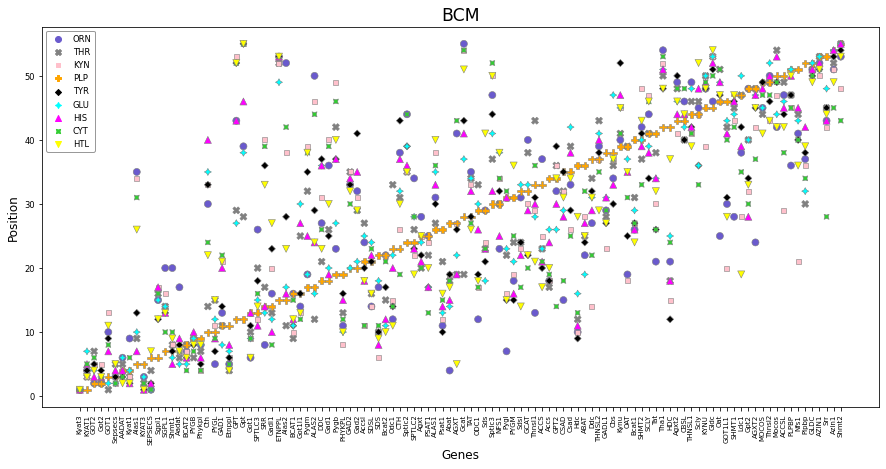

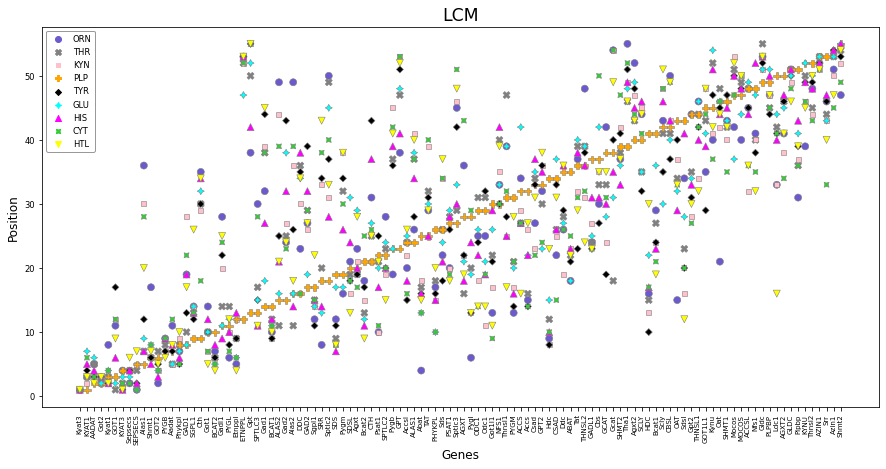

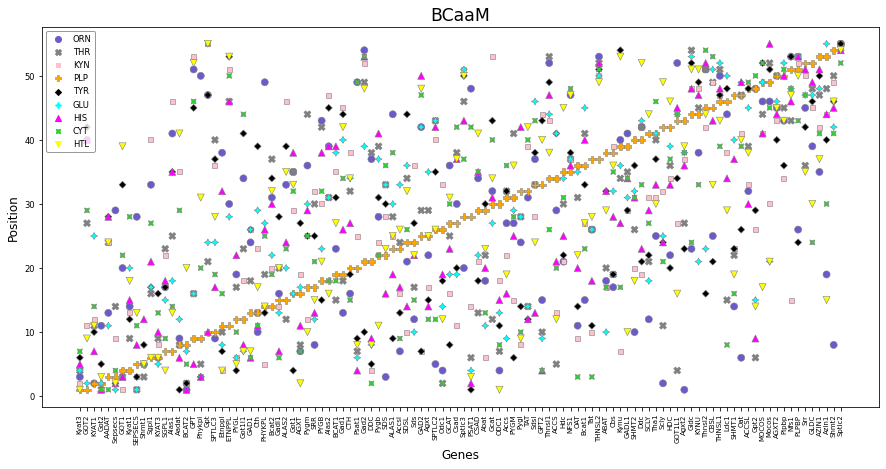

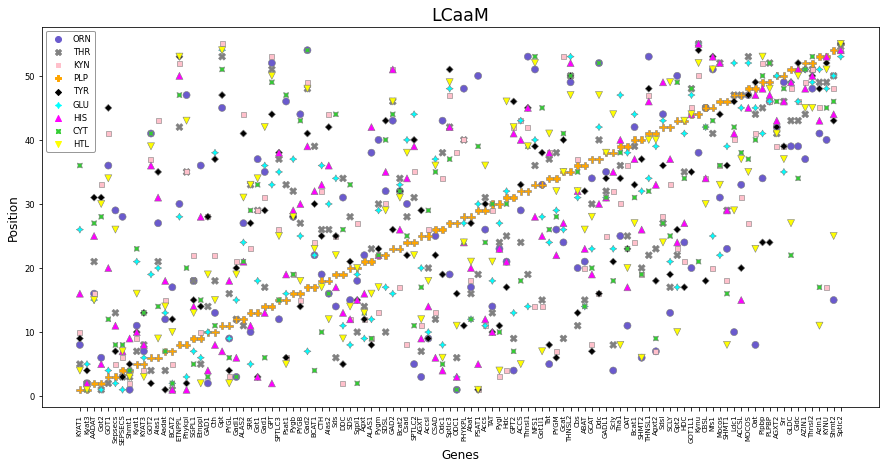

In [48]:
### plotting
for data in all:
    plt.figure(figsize=(15,7))
#     data=all[1]
    criterion=data.columns[0].split(' ')[1]
    data=data.rename(columns=lambda x: x[0:3])
    ax=sns.scatterplot(data=data.sort_values('PLP'),
                       palette={'HIS':'magenta',
                               'CYT':'limegreen',
                               'KYN':'pink',
                               'THR':'gray',
                               'GLU':'cyan',
                               'ORN':'slateblue',
                               'PLP':'orange',
                               'HTL':'yellow',
                               'TYR':'black'},
                       edgecolor='gray',
                       s=50)
    plt.xticks(rotation=90, 
                fontweight='light',
                fontsize='x-large')
    plt.legend(fontsize='small',loc='upper left',edgecolor='gray')
    plt.xticks(fontsize='x-small')
    plt.yticks(fontsize='small')
    ax.set(xlabel="X Label", ylabel = "Y Label")
    plt.xlabel('Genes', fontsize='large')
    plt.ylabel('Position', fontsize='large')
    plt.title(criterion, fontsize='xx-large')
    # ax.set(ylim=(56,0))
    plt.savefig("scatter_plots/total_scatter_"+criterion+".pdf")

# Correlation

In [53]:
correlation=[]
for f in all:
    c=pd.DataFrame(f.corr(method ='pearson').drop([col for col in f.columns if 'PLP' in col],axis=1).iloc[3])
    c.index=c.index.str[0:3]
    correlation.append(c)
total_corr=pd.concat(correlation,axis=1)
total_corr.columns=total_corr.columns.str.rstrip('(kcal/mol)')
total_corr.loc['Mean'] = total_corr.mean()

correlation(total_corr, 'PuBu', 'table_svg/correlation.svg')
total_corr

,PLP BCB,PLP LCB,PLP BCaaB,PLP LCaaB,PLP BCM,PLP LCM,PLP BCaaM,PLP LCaaM
ORN,0.650652,0.646924,0.323785,0.326486,0.637377,0.656929,0.248393,0.314732
THR,0.861159,0.786717,0.511697,0.550116,0.850698,0.775153,0.562593,0.607821
KYN,0.716878,0.721062,0.450645,0.427935,0.598235,0.663091,0.431017,0.372133
TYR,0.736658,0.724790,0.493590,0.539998,0.709422,0.696641,0.446955,0.465746
GLU,0.856099,0.795390,0.693027,0.677774,0.849481,0.806040,0.702233,0.686751
HIS,0.806877,0.826657,0.580395,0.664232,0.792232,0.813154,0.627182,0.654608
CYT,0.670204,0.681464,0.466164,0.498383,0.641066,0.651375,0.479440,0.469207
HTL,0.742858,0.710449,0.461790,0.468180,0.709917,0.668987,0.463197,0.400319
Mean,0.755173,0.736682,0.497637,0.519138,0.723553,0.716421,0.495126,0.496415


# Create maxitab with all merged dataframe

In [24]:
maxitab = []
for f in glob.glob('result/final_result/*PLP*.tsv'):
    df = pd.read_csv(f, sep = '\t')
    df['Entry'] = df[df.columns[0]].str[0:6]
    
    ## open proteome organism ##
    mouse_proteome = pd.read_csv('result/mouse_uniprot.tsv', sep = '\t')
    human_proteome = pd.read_csv('result/human_uniprot.tsv', sep = '\t')
    
    if 'Human' in f:
        dlg = pd.merge(human_proteome[['Entry','EC number','Gene names','Protein names','Organism']],
                       df, on='Entry', how='right')
        organism='Human'
    else:
        dlg = pd.merge(mouse_proteome[['Entry','EC number','Gene names','Protein names','Organism']],
                       df, on='Entry', how='right')
        organism='Mouse' 

    for column in dlg:
        if 'kcal' in column:
            df1 = dlg.sort_values(by=[column]).drop_duplicates(['Entry']).reset_index(drop=True).fillna('-')
            df1.index+=1
##### tab render
#             style_table(df1,column,organism)
###### tab render

            df1[column]=df1.index
            maxitab.append(df1.filter(items=['Entry','Ligand',column]))
        else:
            df_random = dlg.sample(frac=1, random_state=seed).drop_duplicates(['Entry']).reset_index(drop=True)
            df_random.index+=1
            df_random['Random']=df_random.index
            maxitab.append(df_random.filter(items=['Entry','Ligand','Random']))

# Create tab for plotting

In [25]:
pp=[]
tab_position=pd.concat(maxitab).groupby(['Ligand','Entry']).first()
for k,v in enzyme.items():
    pp.append(tab_position.loc[(k,v),:])
ddf=pd.concat(pp)
v=pd.DataFrame(ddf.T.stack().stack())
v.reset_index(inplace=True)
v.rename(columns={'level_0':'Method',0:'Position','ligand':'Ligand'},
         inplace=True)
v['Method'] = v['Method'].replace({'\ \(kcal/mol\)' : ''}, regex=True)
v.sort_values('Method', ascending=True, inplace=True)


# Create Boxenplot+swarmplot with ranking position with ligand hue

10.5


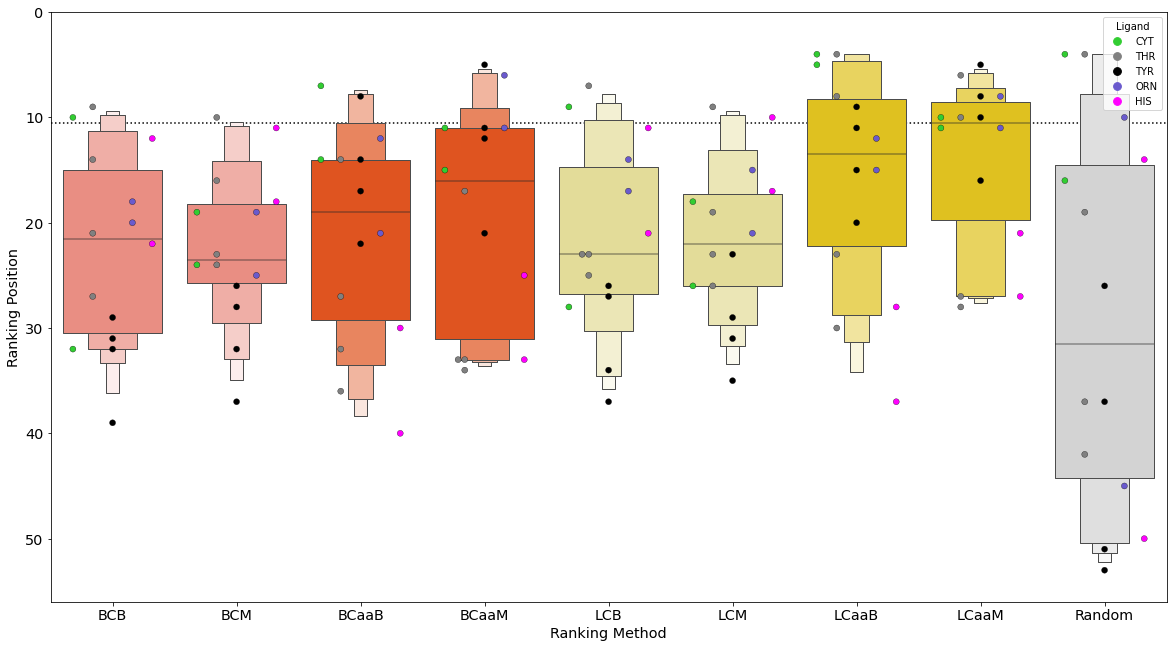

In [26]:
fig, ax = plt.subplots(figsize =(20, 13)) 
bccolor,lccolor='salmon', 'khaki'
bcacolor,lcacolor='orangered', 'gold'
sns.boxenplot(x='Method',y='Position',data=v,
              color='lightorange',
              palette = {'LCB':lccolor,'LCM':lccolor,'LCaaB':lcacolor,'LCaaM':lcacolor,
                         'BCB':bccolor,'BCM':bccolor,'BCaaB':bcacolor,'BCaaM':bcacolor,
                         'Random':'lightgrey'},
              k_depth='full',
              showfliers=False)
p1=sns.swarmplot(x='Method',y='Position',hue='Ligand', data=v,
              dodge=True,
              palette={'HIS':'magenta',
                       'CYT':'limegreen',
                       'KYN':'pink',
                       'THR':'gray',
                       'GLU':'cyan',
                       'ORN':'slateblue',
                       'PLP':'orange',
                       'HTL':'yellow',
                       'TYR':'black'},
              size=6,
              linewidth=0.3)
plt.xticks(rotation=0, 
            fontweight='light',
            fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Ranking Method', fontsize='x-large')
plt.ylabel('Ranking Position', fontsize='x-large')
ax.axhline(min(ddf.quantile(0.5)), color='black',ls=':',
                  alpha = 1,
                  zorder = 0)

ax.set(ylim=(56,0))
plt.gcf().subplots_adjust(bottom=0.25)

plt.savefig('boxenplot_fig_color_no_kyn_glu.pdf')
print(min(ddf.quantile(0.5)))

## QMEAN Distribution

In [27]:
import os
##grep QMN4 *.pdb
qmeans=[]
for qmean in glob.glob('qmean*'):
    sm=pd.read_csv(qmean, sep =r'\s+|:',header=None).drop([1,2,3],axis=1)
    sm['dlg file'] = sm[sm.columns[0]].str.strip('.pdb')
    sm['QMEAN']=sm[4]
    sm=sm.drop([0,4],axis=1)
    qmeans.append(sm)
qmeans=pd.concat(qmeans)
qmeans.sort_values('QMEAN').head(20)

<ipython-input-27-9a4f7833f90e>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  sm=pd.read_csv(qmean, sep =r'\s+|:',header=None).drop([1,2,3],axis=1)


,dlg file,QMEAN
29,Q14CH1_48_490_3a9y.1.B_swissmodel,-4.97
34,Q3UX83-2_102_522_6d0a.1.A_swissmodel,-4.91
76,Q99K01-4_11_489_6eew.1.A_swissmodel,-4.90
74,Q99K01-2_13_490_4rit.1.A_swissmodel,-4.81
50,Q8BH55_226_741_1kl7.1.A_swissmodel,-4.69
3,A2AIG8-2_42_459_4n0b.2.B_swissmodel,-4.66
0,A2AIG8-1_37_482_4n0b.2.B_swissmodel,-4.66
77,Q99K01-5_11_379_5hsj.1.A_swissmodel,-4.62
4,E9Q848_12_308_6tp3.1.A_swissmodel,-4.61
78,Q99K01-5_11_381_6eew.1.A_swissmodel,-4.53


# QMEAN and Size Correlation

In [37]:
corr_qmean,corr_size,totals={},{},[]
for t in glob.glob('result/final_result/*.tsv'):
    ligand=(os.path.basename(t).split('P_')[0]+'P')
    df = pd.read_csv(t, sep = '\t')
    df['Entry'] = df[df.columns[0]].str[0:6]
    df=df.sort_values('Entry')#.drop_duplicates('Entry')
    dlg=df
#     mouse_proteome = pd.read_csv('https://www.uniprot.org/uniprot/?query=organism:10090&columns=id,entry%20name,reviewed,protein%20names,genes,organism,length,ec&format=tab', sep = '\t')
#     human_proteome = pd.read_csv('https://www.uniprot.org/uniprot/?query=organism:9606&columns=id,entry%20name,reviewed,protein%20names,genes,organism,length,ec&format=tab', sep = '\t')
#     human_proteome = pd.read_csv('mouse_uniprot.tsv', sep='\t')
#     dlg = pd.merge(human_proteome[['Entry','Gene names','Protein names','EC number']],df, on='Entry', how='right')#.drop(['Name'], axis=1)
    dlg['dlg file'] = dlg['dlg file'].str.replace('_'+ligand+'.+', '')
    qmean=pd.merge(dlg,qmeans, on='dlg file')
    correlation = qmean[['LCaaM (kcal/mol)','QMEAN']].corr(method='pearson')
    qmean['size']=qmean.groupby(['Entry']).size()
    size=pd.DataFrame(qmean.groupby(['Entry']).size())
    size=size.reset_index()
    total=pd.merge(qmean, size)
    totals.append(total)
    for col in total.drop([0],axis=1):
        if 'kcal' in col:
            corr_size.setdefault(total.Ligand[0],{}).update({col:total[[col,0]].corr(method='pearson')[0][col]})
            corr_qmean.setdefault(total.Ligand[0],{}).update({col:total[[col,'QMEAN']].corr(method='pearson')['QMEAN'][col]})

# min(corr)
# len(total)
# totals=pd.concat(totals)
# {'row1': {'col1': 1, 'col2': 0.5}
corr_size = pd.DataFrame(corr_size).T
corr_size.loc['Mean'] = corr_size.mean()
corr_qmean = pd.DataFrame(corr_qmean).T
corr_qmean.loc['Mean'] = corr_qmean.mean()
corr_qmean.columns=corr_qmean.columns.str.rstrip('(kcal/mol)')
corr_size.columns=corr_size.columns.str.rstrip('(kcal/mol)')


In [59]:
correlation(corr_qmean, 'PuBu_r', 'table_svg/qmean_correlation.svg')
correlation(corr_size, 'PuBu', 'table_svg/size_correlation.svg')

,BCB,LCB,BCaaB,LCaaB,BCM,LCM,BCaaM,LCaaM
ORN,0.380112,0.377390,0.065151,0.006851,0.371783,0.369082,0.083173,0.010143
THR,0.234132,0.225613,0.131790,0.102088,0.255878,0.262067,0.145983,0.066425
KYN,0.242611,0.212138,-0.051482,0.043043,0.236744,0.227733,0.056200,0.109131
PLP,0.053924,0.000339,0.029792,0.005632,0.069786,0.023749,0.038332,0.017396
TYR,0.236816,0.295307,0.122587,0.133384,0.272608,0.303259,0.148092,0.140647
GLU,0.222613,0.200577,0.137006,-0.060485,0.235838,0.233388,0.170556,0.003545
HIS,0.249786,0.223458,0.073856,0.043652,0.274880,0.238778,0.136592,0.088258
CYT,0.237171,0.265995,0.076299,-0.000505,0.206965,0.253709,0.143226,0.070192
HTL,0.240440,0.233199,0.145611,0.076879,0.249211,0.244279,0.184943,0.135625
Mean,0.233067,0.226002,0.081179,0.038949,0.241522,0.239561,0.123011,0.071263


/home/lab83bio/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


([<matplotlib.axis.YTick at 0x7efd296fd8e0>,
 <a list of 9 Text major ticklabel objects>)

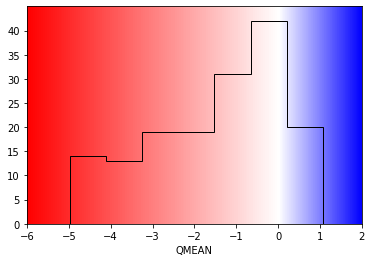

In [60]:
###dist plot qmean
sns.distplot(qmeans['QMEAN'], kde=False,hist_kws={"histtype": "step",
                            "alpha": 1, "color": "black"})
gradient = np.linspace(0, 1, 10000).reshape(1, -1)
plt.imshow(gradient , extent=[-6, 2, 0, 45], aspect='auto', cmap='bwr_r',norm=MidpointNormalize(midpoint=0.752))
plt.yticks(np.arange(0, 45, 5))
# bar = plt.cm.ScalarMappable(cmap="bwr_r", norm=mp.Normalize(vmin=0, vmax=1.2))
# bar.set_array([])
# plt.colorbar(bar, label="weight")
# plt.savefig('Qmean_dist.pdf')